# DS5110 Final Project Assignment

## The Ed Squad
Shilpa Narayan (smn7ba) <br>
Ashlie Ossege (ajo5fs) <br>
Jamie Oh (hso6b) <br>
Isaac Stevens (is3sb) <br>

### About data
AMERICAN COMMUNITY SURVEY 2015-2019 5-YEAR SAMPLE
5-in-100 national random sample of the population
Contains all households and persons from the 1% ACS samples for 2015, 2016, 2017, 2018, and 2019 identifiable by year.
The data include persons in group quarters.
This is a weighted sample.
The smallest identifiable geographic unit is the PUMA, containing at least 100,000 persons. PUMAs do not cross state boundaries.

The lowest unit of geography in the microdata files is still the PUMA. PUMAs contain at least 100,000 people.
Aggregate data (but not microdata) is currently available from the Census Bureau for geographic areas as small as block groups, but only for the entire 2005-2009 period.

PERNUM numbers all persons within each household consecutively in the order in which they appear on the original census or survey form.
When combined with SAMPLE and SERIAL, PERNUM uniquely identifies each person within the IPUMS.

MULTYEAR identifies the actual year of survey in multi-year ACS/PRCS samples.


For example, the 3-year ACS and PRCS data files each include cases from three single-year files.
For these multi-year samples, the YEAR variable identifies the last year of data (2007 for the 2005-2007 3-year data; 2008 for the 2006-2008 data; and so on).
MULTYEAR gives the single-year sample from which the case was drawn (2005, 2006, or 2007 for the 2005-2007 3-year data; 2006, 2007, or 2008 for the 2006-2008 3-year data; and so on).

https://usa.ipums.org/usa/acs_multyr.shtml

In [1]:
#import spark packages
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import SQLContext
#import mlLib libraries for classification
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder,TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, LogisticRegression, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA, Binarizer
from pyspark.mllib.evaluation import MulticlassMetrics,BinaryClassificationMetrics
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [2]:
#import python packages too for visualizations
%matplotlib inline
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200000)
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("white")

In [3]:
#set seed so results are reproducible
seed = 42

In [4]:
# set up the spark session
spark = SparkSession \
    .builder \
    .master("local") \
    .appName("Ed Squad Project") \
    .config("spark.executor.memory", '200g') \
    .config('spark.executor.cores', '8') \
    .config('spark.cores.max', '8')\
    .config("spark.driver.memory", '200g')\
    .getOrCreate()

sc = spark.sparkContext    
sqlContext = SQLContext(spark)

In [5]:
sc.uiWebUrl

'http://udc-ba26-32c1:4040'

## Read In Data

In [6]:
#import acs sample data for 2015-2019 and south region
data = spark.read.csv('/project/ds5559/ds5110_project_snoo/acs_15_19_south_puma.csv', inferSchema="true", header="true")

In [7]:
#cache the dataset to perform eda functions later
data_c=data.cache()

## Preprocess Data

In [8]:
#Binarization is the process of thresholding numerical features to binary (0/1) features.
#Binarizer takes a cvector or double, therefore casting EDUC column as doubletype to binarize as label
data_c = data_c.withColumn("EDUC",col("EDUC").cast(DoubleType()))
binarizer = Binarizer(threshold=6.0, inputCol="EDUC", outputCol="label")
data_label = binarizer.transform(data_c)
data_label_c = data_label.cache()

In [9]:
#checkign resuklts for sanity that EDUC is binarized accurately as 1 if >6 and otherwise 0.
data_label_c.select(['EDUC','label']).distinct().sort('EDUC').show()

+----+-----+
|EDUC|label|
+----+-----+
| 0.0|  0.0|
| 1.0|  0.0|
| 2.0|  0.0|
| 3.0|  0.0|
| 4.0|  0.0|
| 5.0|  0.0|
| 6.0|  0.0|
| 7.0|  1.0|
| 8.0|  1.0|
|10.0|  1.0|
|11.0|  1.0|
+----+-----+



In [10]:
#check the count for EDUC>6 or verify if flag was populated correctly
data_label_c.filter(data_label.EDUC>6).count()

2470127

In [11]:
#Verify the flag count. Should match number above
data_label_c.filter(data_label.label!=0).count()

2470127

## EDA

### Full Data EDA

In [12]:
#exploring shape of data which is number of rows and columns in the data
print("Rows, Columns = ",(data_c.count(), len(data_c.columns)))

Rows, Columns =  (5965249, 137)


In [80]:
#check counts by label
data_label_c.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|  0.0|3495122|
|  1.0|2470127|
+-----+-------+



In [13]:
#exploring number of years in the data set
data_c.select('MULTYEAR').distinct().sort('MULTYEAR').show()

+--------+
|MULTYEAR|
+--------+
|    2015|
|    2016|
|    2017|
|    2018|
|    2019|
+--------+



### Education EDA

In [14]:
'''
Education field - we made a binary variable (above 6, and below)
EDUC                Educational attainment [general version]
00                  N/A or no schooling
01                  Nursery school to grade 4
02                  Grade 5, 6, 7, or 8
03                  Grade 9
04                  Grade 10
05                  Grade 11
06                  Grade 12
07                  1 year of college
08                  2 years of college
09                  3 years of college
10                  4 years of college
11                  5+ years of college
'''

'\nEducation field - we made a binary variable (above 6, and below)\nEDUC                Educational attainment [general version]\n00                  N/A or no schooling\n01                  Nursery school to grade 4\n02                  Grade 5, 6, 7, or 8\n03                  Grade 9\n04                  Grade 10\n05                  Grade 11\n06                  Grade 12\n07                  1 year of college\n08                  2 years of college\n09                  3 years of college\n10                  4 years of college\n11                  5+ years of college\n'

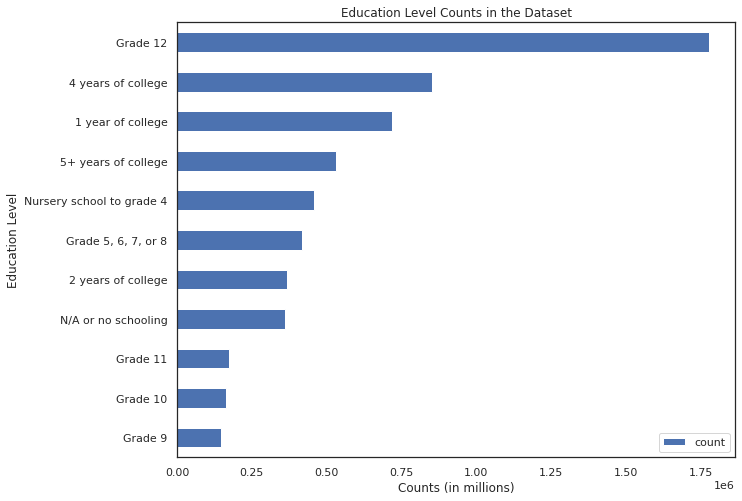

In [15]:
#create a map to pass to yticks to have readable lables
educ_map = {0:'N/A or no schooling',\
1:'Nursery school to grade 4',\
2:'Grade 5, 6, 7, or 8',\
3:'Grade 9',\
4:'Grade 10',\
5:'Grade 11',\
6:'Grade 12',\
7:'1 year of college',\
8:'2 years of college',\
10:'4 years of college',\
11:'5+ years of college'}
#group by EDUC and and check the proportion in the datset for each level.
data_edu = data.groupby('EDUC').count()
data_edu_c = data_edu.cache()
#convert to pandas dataframe to visualize
data_edu_c = data_edu_c.toPandas()
#Add labels column for better readability
data_edu_c['Education Level'] = data_edu_c['EDUC'].map(educ_map)
#barplot is more redable when it is sorted in order of counts
data_edu_c  = data_edu_c.sort_values(by='count')
#create the barplot
data_edu_c.plot(x ='Education Level', y="count", kind='barh')
#set title, labels
plt.title("Education Level Counts in the Dataset")
plt.xlabel("Counts (in millions)")
plt.ylabel("Education Level")
plt.show() # no 9's!

### Gender EDA

In [16]:
'''
SEX                 Sex
1                   Male
2                   Female

label              
0                 Not Educated
1                 Educated
'''

'\nSEX                 Sex\n1                   Male\n2                   Female\n\nlabel              \n0                 Not Educated\n1                 Educated\n'

In [17]:
#exploring count by SEX to see if there is an imbalance in the population
data_c.groupBy('SEX').count().show()

+---+-------+
|SEX|  count|
+---+-------+
|  1|2897686|
|  2|3067563|
+---+-------+



In [18]:
#exploring counts of label by SEX 
data_label_c.groupBy(['label','SEX']).count().show()

+-----+---+-------+
|label|SEX|  count|
+-----+---+-------+
|  1.0|  2|1328613|
|  0.0|  1|1756172|
|  1.0|  1|1141514|
|  0.0|  2|1738950|
+-----+---+-------+



In [19]:
#exploring counts of label by SEX and calculating proprotions of educated vs not educated
male_0 = data_label_c[(data_label_c['SEX'] == 1) & (data_label_c['label'] == 0)].count()
male_1 = data_label_c[(data_label_c['SEX'] == 1) & (data_label_c['label'] == 1)].count()
female_0 = data_label_c[(data_label_c['SEX'] == 2) & (data_label_c['label'] == 0)].count()
female_1 = data_label_c[(data_label_c['SEX'] == 2) & (data_label_c['label'] == 1)].count()
male = male_0 + male_1
female = female_0 + female_1
total = male + female
print("Total (male+female) = ",total,"| Rows = ", data.count())

Total (male+female) =  5965249 | Rows =  5965249


In [20]:
# Male - Ed 0 vs Ed 1 proprotions
print("Proportion of Male Not Educated (%): ",round((male_0/(male_0+male_1))*100,2),\
      " | Proportion of Male Educated (%): ", round((male_1/(male_0+male_1))*100,2))

Proportion of Male Not Educated (%):  60.61  | Proportion of Male Educated (%):  39.39


In [21]:
# Female - Ed 0 vs Ed 1 proprotions
print("Proportion of Female Not Educated (%): ",round((female_0/(female_0+female_1))*100,2),\
      " | Proportion of Female Educated (%): ",round((female_1/(female_0+female_1))*100,2))

Proportion of Female Not Educated (%):  56.69  | Proportion of Female Educated (%):  43.31


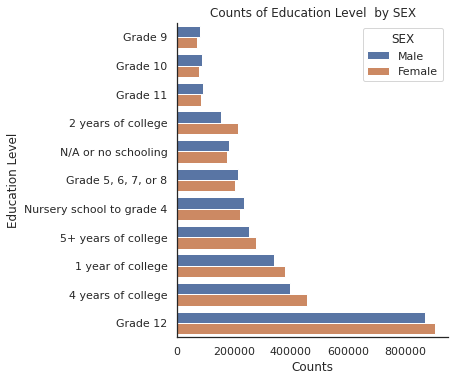

In [22]:
#Comparing education level counts against male and female
#group by educ and sex 
df2 = data.groupBy('EDUC', 'SEX').count()#.orderBy('EDUC', 'SEX')
df2_c = df2.cache()
#convert to pandas dataframe for visualizing
df2_c = df2_c.toPandas()
#add meaningful labels for EDUC
df2_c['Education Level'] = df2_c['EDUC'].map(educ_map)
#barplot is more redable when it is sorted in order of counts
df2_c  = df2_c.sort_values(by='count')
#create the plot using seaborn library
fg = sns.catplot(x='count', y='Education Level', hue='SEX', data=df2_c, kind='bar',orient='h', legend_out=False,aspect=10/8);
#set x and y labels and also labels for the legend
fg.set_xlabels('Counts');
fg.set_ylabels('Education Level');
new_labels = ['Male', 'Female']
for old, new in zip(fg._legend.texts, new_labels): old.set_text(new);
#set title of the plot
plt.title('Counts of Education Level  by SEX');

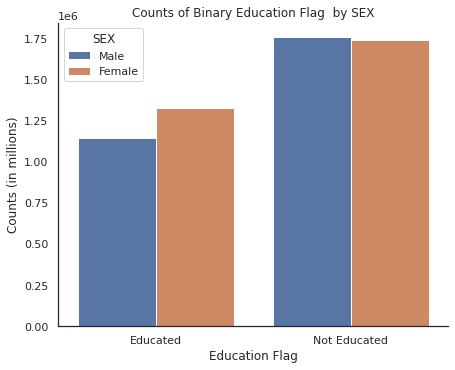

In [23]:
#Comparing education flag counts against male and female
#group by education flag(label) and sex
df3 = data_label.groupBy('label', 'SEX').count().orderBy('label', 'SEX')
df3_c = df3.cache()
#convert to pandas dataframe
df3_c = df3_c.toPandas()
#add meaningful labels to education flag
df3_c['Education Flag'] = df3_c['label'].map({0:'Not Educated',1:'Educated'})
#barplot is more redable when it is sorted in order of counts
df3_c  = df3_c.sort_values(by='count')
#create the plot usinmg seaborn library
fg = sns.catplot(x='Education Flag', y='count', hue='SEX', data=df3_c, kind='bar', legend_out=False,aspect=10/8)
#set x and y labels
plt.xlabel('Education Flag')
plt.ylabel('Counts (in millions)')
#set labels for legend
new_labels = ['Male', 'Female']
for old, new in zip(fg._legend.texts, new_labels): old.set_text(new)
#set plot title
plt.title('Counts of Binary Education Flag  by SEX');

### Balance the data for similar number of EDUC FLAG

In [24]:
#majority sample is for larger class when we use a ratio by sampling smaller class count out of larger class count
sampled_majority_df = data_label.filter(data_label['label']==0)\
    .sample(False,data_label.filter(data_label['label']==1).count()/data_label.filter(data_label['label']==0).count(), seed=seed)
#minor sample is kept as is
minor_df = data_label.filter(data_label['label']==1).sample(False,1.0, seed=seed)
#combine both in a dataframe for a balanced sample
df = sampled_majority_df.unionAll(minor_df)
df_c = df.cache()

In [25]:
#check results
df_c.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|  0.0|2471011|
|  1.0|2470127|
+-----+-------+



## EDA On Sampled Data

In [26]:
def createSampleData(df,cols,sampleweight):
    '''
    function to create a sample of the data based on certain columns and a sample weight
    '''
    df_small = df.select(cols)
    sampled = df_small.sampleBy("MULTYEAR", fractions={2015:sampleweight, 2016: sampleweight, 2017:sampleweight, 2018:sampleweight, 2019:sampleweight}, seed=seed)
    return sampled

In [27]:
hhtype_groups = df.groupBy("HHTYPE").count().sort(col("count").desc())

In [28]:
#udf to map hhtype
def mapHhtype(value):
    hhtype_dict = {0:'N/A',\
            1: 'Married-couple family household',\
            2: 'Male householder, no wife present',\
            3: 'Female householder, no husband present',\
            4: 'Male householder, living alone',\
            5: 'Male householder, not living alone',\
            6: 'Female householder, living alone',\
            7: 'Female householder, not living alone',\
            9: 'HHTYPE could not be determined'}
    return hhtype_dict.get(value)

In [29]:
hhtype_function = F.udf(mapHhtype, StringType())
hhtype_groups = hhtype_groups.withColumn("Household Type", hhtype_function("hhtype"))
hhtype_df = hhtype_groups.toPandas()

In [30]:
hhtype_df

HHTYPE    count                          Household Type
0       1  2976745         Married-couple family household
1       3   592841  Female householder, no husband present
2       6   334681        Female householder, living alone
3       9   287870          HHTYPE could not be determined
4       4   240298          Male householder, living alone
5       0   220397                                     N/A
6       2   165945       Male householder, no wife present
7       5    66458      Male householder, not living alone
8       7    55903    Female householder, not living alone

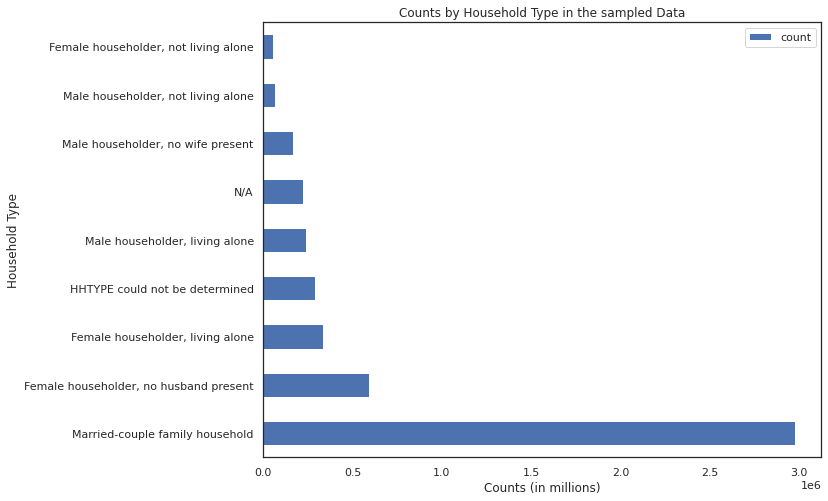

In [31]:
hhtype_df.plot.barh(x='Household Type', y='count', title = "House Hold Types Ordered by Count");
plt.ylabel('Household Type');
plt.xlabel('Counts (in millions)');
plt.title('Counts by Household Type in the sampled Data');

In [32]:
#removing cols which are repeated and may be highly correlated so that PCA components are more meaningful
#the columns were removed in iteration process of looking at the correlation matirx below multiple times.
cols = df.drop('_c0','CLUSTER','CBSERIAL','STRATA','HHWT','EDUCD',\
 'INCSUPP',\
 'INCWAGE',\
 'INCBUS00',\
 'INCSS',\
 'INCWELFR',\
 'INCINVST',\
 'INCRETIR',\
 'INCSUPP',\
 'INCOTHER',\
 'INCEARN',\
 'RACE',\
 'RACED',\
 'SEI',\
 'CLASSWKRD',\
 'GRADEATTD',\
 'EMPSTATD',\
 'MULTGEND',\
 'OWNERSHPD',\
 'BPLD',\
 'VETSTATD',\
 'YEAR','SAMPLE','SERIAL','PERNUM','MULTYEAR','RELATED','EDUC').columns

In [33]:
#creating sampled dataset (sampled)
selected_cols=[cols for cols in cols if cols not in['label']]
sampled = createSampleData(df,cols,0.1)
sampled_c = sampled.cache()

In [81]:
#length of selected cols
len(selected_cols)

106

In [34]:
corr_df = sampled_c.toPandas()[selected_cols]

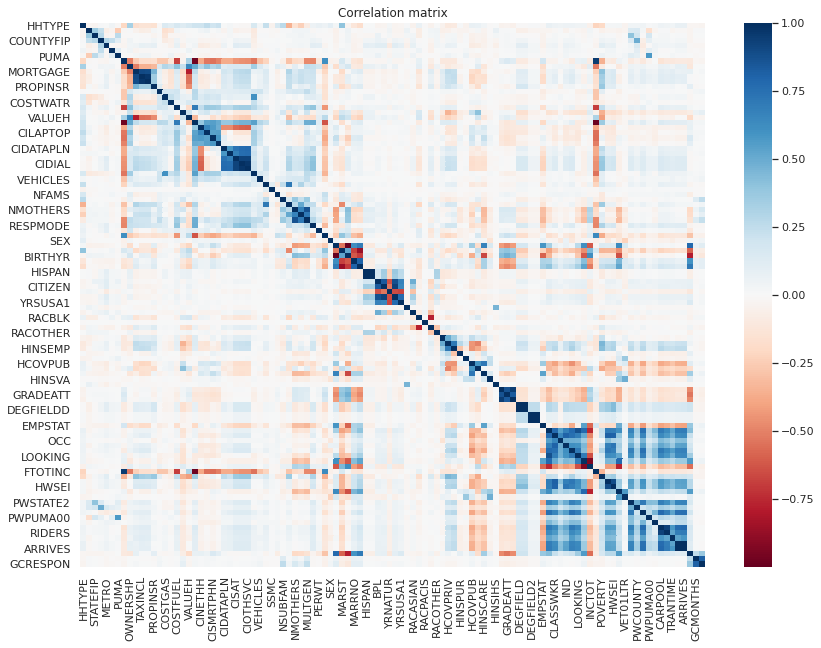

In [35]:
#View Correlation 
#displaying only limited columns
corr = corr_df.corr()
plt.figure(figsize = (14, 10))
sns.heatmap(corr, cmap="RdBu",annot = False)
            #xticklabels=corr.columns.values,
            #yticklabels=corr.columns.values)
plt.title('Correlation matrix')
plt.show()

## Model Construction

In [36]:
split_ratio = [0.7,0.3]
folds = 3
threads = 8
evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')

### Baseline Logistic Regression Model With Only 36 Features

In [37]:
#Select Only These 36 Features for Baseline Model (roi = rows of interest)
roi = ["HHTYPE","REGION","STATEFIP","COUNTYFIP","METRO","COSTELEC","COSTGAS","COSTWATR","COSTFUEL","FOODSTMP",
       "CINETHH","CILAPTOP", "CISMRTPHN","CITABLET","VEHICLES","COUPLETYPE","NFAMS","NMOTHERS","NFATHERS",
       "CITIZEN","YRSUSA1","RACAMIND","RACASIAN","RACBLK","RACPACIS" ,"RACWHT","RACOTHER","HCOVANY","EMPSTAT",
       "LABFORCE","CLASSWKR","UHRSWORK","VETSTAT","TRANWORK","GCHOUSE","label"]

In [38]:
sampled_roi = sampled.select(roi)

In [39]:
#Assemble Features using VectorAssembler
baseline_assembler = VectorAssembler(inputCols=[column for column in roi if column not in ["label"]], outputCol="features") 
baseline_tr = baseline_assembler.transform(sampled_roi)

#train test split
baseline_training, baseline_test = baseline_tr.randomSplit(split_ratio, seed=seed)

#declare model
lr_baseline = LogisticRegression(labelCol='label',
                        featuresCol='features',
                        maxIter=10, 
                        regParam=0.1, 
                        elasticNetParam=0.8)

#Fit model
lrModel_baseline = lr_baseline.fit(baseline_training)

#Predict on test data
lrPred_baseline = lrModel_baseline.transform(baseline_test)
lrPred_baseline_c = lrPred_baseline.cache()

### Evaluate Baseline Model

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
def createLabelsCMandPlot(preds):
    ##saving labels in a list to pass to the plot
    class_temp = preds.select("label").groupBy("label")\
                            .count()
    class_temp_cache = class_temp.cache()
    class_temp_cache = class_temp_cache.toPandas()
    class_temp_cache = class_temp_cache["label"].values.tolist()
    y_true = preds.select("label")
    y_true_c = y_true.cache()
    y_true_c = y_true_c.toPandas()
    y_pred = preds.select("prediction")
    y_pred_c = y_pred.cache()
    y_pred_c = y_pred_c.toPandas()
    
    plot_confusion_matrix(confusion_matrix(y_true_c, y_pred_c,class_temp_cache), classes=['Not Educated','Educated'], normalize=True,
                      title='Normalized confusion matrix')

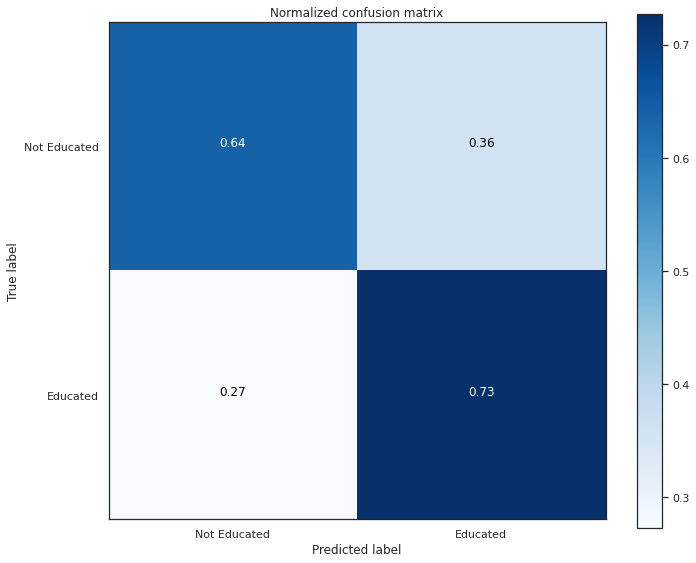

In [42]:
#call the function to evaluate and produce confusion matrix
createLabelsCMandPlot(lrPred_baseline_c)

In [43]:
def classificationMetrics(preds):
    #calcualte classification report
    TN = preds.filter('prediction = 0 AND label = prediction').count()
    TP = preds.filter('prediction = 1 AND label = prediction').count()
    FN = preds.filter('prediction = 0 AND label <> prediction').count()
    FP = preds.filter('prediction = 1 AND label <> prediction').count()
    # show confusion matrix
    preds.groupBy('label', 'prediction').count().show()
    preds_c = preds.cache()
    # calculate metrics by the confusion matrix
    accuracy = (TN + TP) / (TN + TP + FN+ FP)
    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)
    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP + FN)
    if precision + recall == 0:
        F = 0
    else:
        F =  2 * (precision*recall) / (precision + recall)
    # calculate auc
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction",
                                          labelCol="label",
                                          metricName="areaUnderPR")
    auc = evaluator.evaluate(preds_c)
    print('precision: %0.3f' % precision)
    print('recall: %0.3f' % recall)
    print('accuracy: %0.3f' % accuracy)
    print('F1 score: %0.3f' % F)
    print('AUC: %0.3f' % auc)

In [44]:
#call the function to display classification metrics
classificationMetrics(lrPred_baseline)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|53727|
|  0.0|       1.0|26344|
|  1.0|       0.0|20126|
|  0.0|       0.0|46821|
+-----+----------+-----+

precision: 0.671
recall: 0.727
accuracy: 0.684
F1 score: 0.698
AUC: 0.648


### Vector Assemble all features

In [45]:
#pass all the features into vector assembler to create a vector format to pass tto the classification model
assembler = VectorAssembler(inputCols=[cols for cols in cols if cols!='label'], outputCol="features") 
transformed = assembler.transform(sampled)

#register table as sql table and keep only columns of interest and save in a new dataframe. This can be done without using SQl as well.
transformed.registerTempTable('transformed_tbl')
transformed_df = sqlContext.sql('select label,features from transformed_tbl')
transformed_df_c = transformed_df.cache()
transformed_df_c.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(106,[0,1,2,6,7,8...|
|  0.0|[9.0,32.0,1.0,0.0...|
|  0.0|(106,[0,1,2,6,7,8...|
|  0.0|(106,[0,1,2,3,4,6...|
|  0.0|[4.0,32.0,1.0,0.0...|
+-----+--------------------+
only showing top 5 rows



### Split Data Into Train Test Split

In [46]:
def splitData(dataframe,split_ratio,seed):
    '''
    function to split the data into train and test, and cache the resulting dataframe
    '''
    training_data, test_data = dataframe.randomSplit(split_ratio, seed=seed)
    cached_tr = training_data.cache()
    cached_test = test_data.cache()
    return cached_tr,cached_test

In [47]:
#train test split on sampled data
training_data, test_data = splitData(transformed_df_c,split_ratio,seed)

### Scale Data to Prepare for PCA

In [48]:
#scale the training data to use in pipeline
scaler_train = StandardScaler(inputCol="features", outputCol="scaledFeatures")

### PCA

In [49]:
#pca to reduce 100 odd features into principal components - on training data only because that is our model
pca_model = PCA(k=10, inputCol = "scaledFeatures", outputCol = "pca_features")

### Logistic Regression Pipeline and Evaluation

In [50]:
#create a logistic regression model to pass into pipeline
lr = LogisticRegression(labelCol='label',
                        featuresCol='pca_features',
                        maxIter=10, 
                        regParam=0.1, 
                        elasticNetParam=0.8)

#creating a pipeline with the pca and model to use
lr_pipeline = Pipeline(stages = [scaler_train, pca_model, lr])

lr_model = lr_pipeline.fit(training_data)
lrPred = lr_model.transform(test_data)
lrPred_c = lrPred.cache()

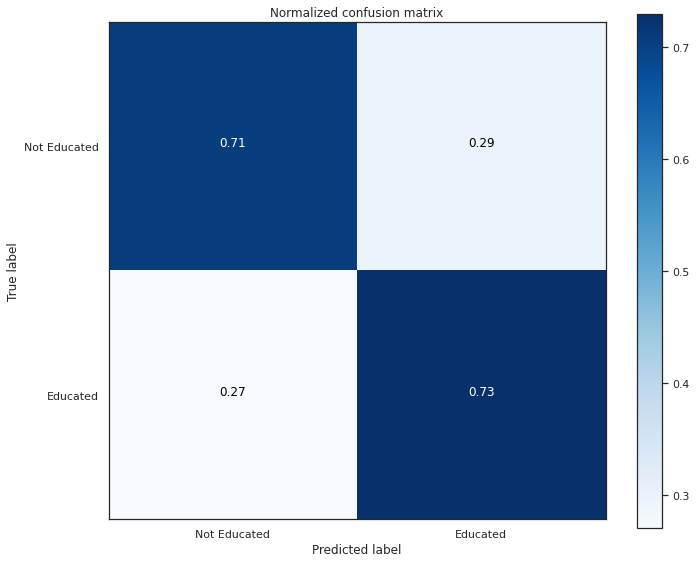

In [51]:
createLabelsCMandPlot(lrPred_c)

In [52]:
classificationMetrics(lrPred_c)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|53885|
|  0.0|       1.0|21576|
|  1.0|       0.0|19968|
|  0.0|       0.0|51589|
+-----+----------+-----+

precision: 0.714
recall: 0.730
accuracy: 0.717
F1 score: 0.722
AUC: 0.685


### Models

In [53]:
#create a SVM classifier model to pass into pipeline
lsvc = LinearSVC(labelCol = "label", featuresCol = "pca_features", maxIter=10, regParam=0.1)

#create a Gradient Boosting classifier model to pass into pipeline
gb = GBTClassifier(labelCol = "label", featuresCol = "pca_features", maxDepth=10)

#create a Random Forest classifier model to pass into pipeline
rf = RandomForestClassifier(labelCol = "label", featuresCol = "pca_features", maxDepth=15)

### Param Grids

In [54]:
#SVM param grid
paramGrid_svm = ParamGridBuilder() \
    .addGrid(pca_model.k,[10,20,30])\
    .addGrid(lsvc.regParam, [0.1,0.5,1]) \
    .build()

#Gradient param grid
paramGrid_gbt = ParamGridBuilder() \
             .addGrid(gb.maxIter, [10, 15]) \
             .addGrid(gb.maxBins, [10, 20]) \
             .build()

#Random Forest param grid
paramGrid_rf = ParamGridBuilder() \
        .addGrid(rf.numTrees, [20, 30]) \
        .build() 

In [55]:
def modelTrainingCrossVal(model,paramGrid,evaluator,folds,seed,threads,scaler_train, pca_model, train_data):
    '''
    This function creates a cross validator. Cross vlaidator takes a model as an estimator, param grid for a model, evaluator, number of folds, seed and threads.
    Creates a pipeline and passes scaled data, pca model and cross validator to a pipeline. It saves time by passing cross validator into pipeline,
    instead of piepeline as an estimator. Otherwise it build a piepeline for each model the cross validator evaluates. Which is not efficient in this case.
    '''
    crossval = CrossValidator(estimator = model,\
                                        estimatorParamMaps=paramGrid,\
                                        evaluator = evaluator,\
                                        numFolds= folds,seed=seed,
                                        parallelism=threads)

    #creating a pipeline with the pca and model to use in the cross validator
    pipeline = Pipeline(stages = [scaler_train, pca_model, crossval])
    pipeline_m = pipeline.fit(train_data)
    return pipeline_m

def evalModelandTrainingMetrics(model):
    print("Training Model AUCROC from Cross-validation:",model.avgMetrics)

### Support Vector Machine Pipeline, Model, Cross Validation and Evaluation

In [56]:
#train model
svm_pipeline = Pipeline(stages = [scaler_train, pca_model, lsvc])

#passs the model with various combinations of the parameters and it will pick the best one. 
crossval = CrossValidator(estimator = svm_pipeline,\
                                        estimatorParamMaps=paramGrid_svm,\
                                        evaluator = evaluator,\
                                        numFolds= folds,seed=seed,
                                        parallelism=threads)


#this is our best model - fit the training data
cv_svm_model = crossval.fit(training_data)

#Evaluate Model
evalModelandTrainingMetrics(cv_svm_model)

Training Model AUCROC from Cross-validation: [0.873362221822358, 0.8685976520724132, 0.8748340849749404, 0.9039601318041981, 0.909029542352356, 0.9082432948338313, 0.9107863820346342, 0.9160516117726214, 0.9139125691441286]


In [57]:
#Get the hyperparameters from the pca and for the SVM model
svm_bestPipeline = cv_svm_model.bestModel

#pca
svm_pca = svm_bestPipeline.stages[1]
print("Optimal pca k: {}".format(svm_pca.getK()))

#SVM parameters
svm_model = svm_bestPipeline.stages[2]
print("RegParam parameter: {}".format(svm_model.getRegParam()))

Optimal pca k: 30
RegParam parameter: 0.5


In [58]:
#predict and evaluate the svm model
svmPred = cv_svm_model.transform(test_data)
svmPred_c = svmPred.cache()

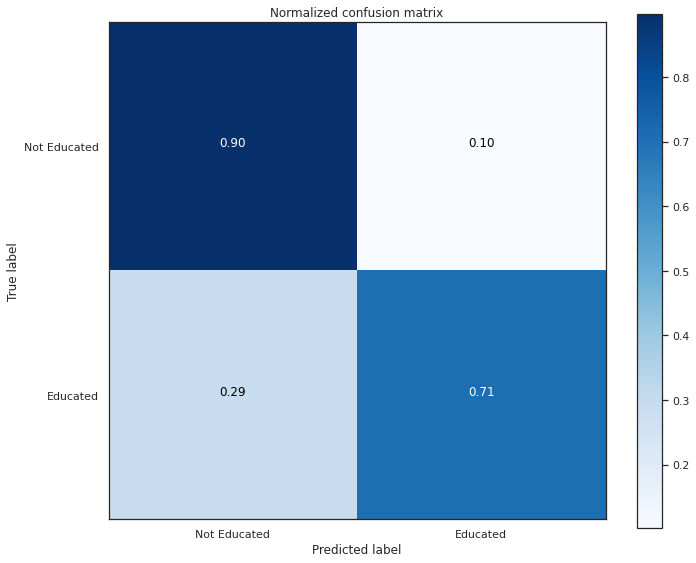

In [59]:
#plot confusion matrix
createLabelsCMandPlot(svmPred_c)

In [60]:
#print classification metrics
print("SVM Classification Metrics for Test Data:")
print(" ")
classificationMetrics(svmPred_c)

SVM Classification Metrics for Test Data:
 
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|52291|
|  0.0|       1.0| 7442|
|  1.0|       0.0|21562|
|  0.0|       0.0|65723|
+-----+----------+-----+

precision: 0.875
recall: 0.708
accuracy: 0.803
F1 score: 0.783
AUC: 0.821


### Gradient Boosting Pipeline, Model, Cross Validation and Evaluation

In [61]:
#train model
gb_pipe_m = modelTrainingCrossVal(gb,paramGrid_gbt,evaluator,folds,seed,threads,scaler_train, pca_model, training_data)

In [62]:
#Evaluate Model
evalModelandTrainingMetrics(gb_pipe_m.stages[2])

Training Model AUCROC from Cross-validation: [0.9050357799730784, 0.9067666637856591, 0.9065153549761953, 0.9084868160253413]


In [63]:
#Get the hyperparameters from the pca and for the GB model
cv_gb_model = gb_pipe_m.stages[2].bestModel

#GB parameters
print("Max Iter parameter: {}".format(cv_gb_model.getMaxIter()))
print("Max bins parameter: {}".format(cv_gb_model.getMaxBins()))

Max Iter parameter: 15
Max bins parameter: 20


In [64]:
#predict and evaluate the gb model
gbPred = gb_pipe_m.transform(test_data)
gbPred_c = gbPred.cache()

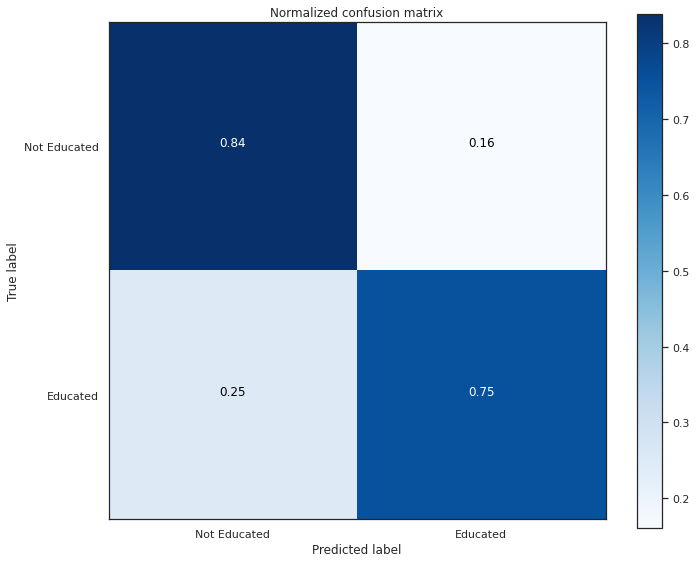

In [65]:
#plot confusion matrix
createLabelsCMandPlot(gbPred_c)

In [66]:
#print classification metrics
print("GBT Classification Metrics for Test Data:")
print(" ")
classificationMetrics(gbPred_c)

GBT Classification Metrics for Test Data:
 
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|55707|
|  0.0|       1.0|11753|
|  1.0|       0.0|18146|
|  0.0|       0.0|61412|
+-----+----------+-----+

precision: 0.826
recall: 0.754
accuracy: 0.797
F1 score: 0.788
AUC: 0.786


### Random Forest Pipeline, Model, Cross Validation and Evaluation

In [67]:
#train model
rf_pipe_m = modelTrainingCrossVal(rf,paramGrid_rf,evaluator,folds,seed,threads,scaler_train, pca_model, training_data)

In [68]:
#Evaluate Model
evalModelandTrainingMetrics(rf_pipe_m.stages[2])

Training Model AUCROC from Cross-validation: [0.9123723780939019, 0.9133265438523321]


In [69]:
#Get the hyperparameters from the pca and for the RF model
rf_model = rf_pipe_m.stages[2].bestModel

#RF parameters
print("Num Trees parameter: {}".format(rf_model.explainParam('numTrees')))

Num Trees parameter: numTrees: Number of trees to train (>= 1). (default: 20, current: 30)


In [70]:
#predict and evaluate the rf model
rfPred = rf_pipe_m.transform(test_data)
rfPred_c = rfPred.cache()

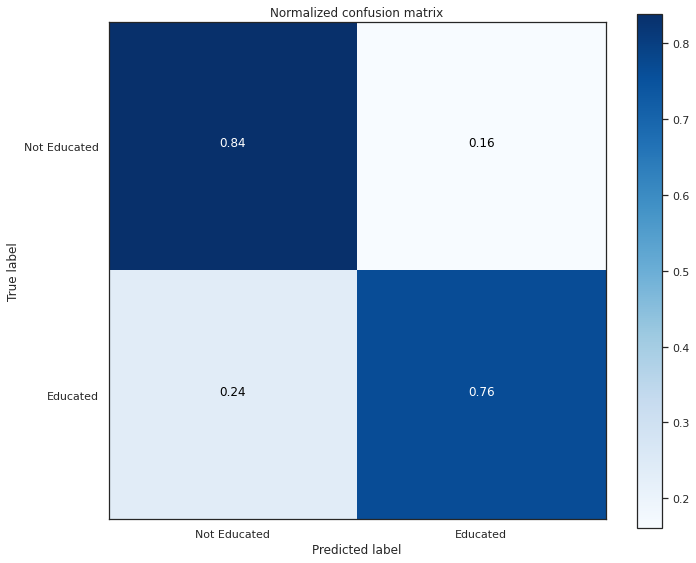

In [71]:
#plot confusion matrix
createLabelsCMandPlot(rfPred_c)

In [72]:
#print classification metrics
print("RF Classification Metrics for Test Data:")
print(" ")
classificationMetrics(rfPred_c)

RF Classification Metrics for Test Data:
 
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|56360|
|  0.0|       1.0|11753|
|  1.0|       0.0|17493|
|  0.0|       0.0|61412|
+-----+----------+-----+

precision: 0.827
recall: 0.763
accuracy: 0.801
F1 score: 0.794
AUC: 0.789


### Interpretation of PCA

Explained Variance:  [0.1309759597302075,0.08684184800315224,0.07198521655484985,0.054104316748693475,0.043177461690147044,0.032747564586555145,0.027283184285344698,0.021730785563836088,0.020756421482399815,0.020269617575580077]


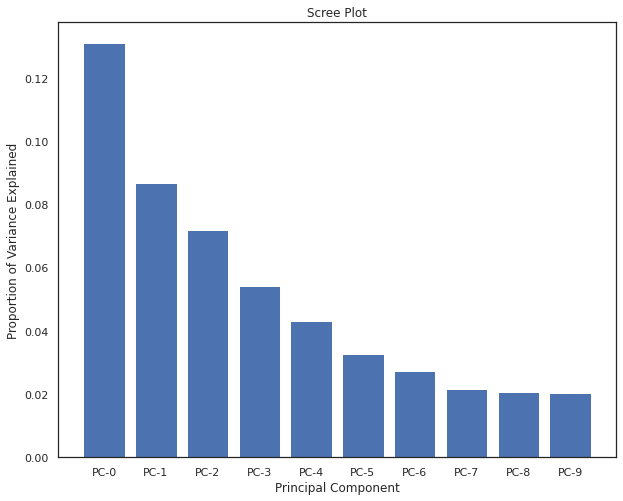

In [73]:
##PCA Loadings
pipe = rf_pipe_m.stages[1]
exp_var = pipe.explainedVariance
print("Explained Variance: ",exp_var)
rows = pipe.pc.toArray().tolist()
pca_components=['PC-0','PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9']#,\
                #'PC-11','PC-12','PC-13','PC-14','PC-15','PC-16','PC-17','PC-18','PC-19']
#screeplot
plt.bar(pca_components,exp_var)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [74]:
#create a spark dataframe with pca loadings, componetns and column names for further analysis
df_pca = spark.createDataFrame(rows,pca_components)
df_pandas = df_pca.toPandas()
df_pandas.index = selected_cols
df_pandas.sort_values(by='PC-0', ascending=False)

PC-0      PC-1      PC-2      PC-3      PC-4      PC-5  \
INCTOT      0.158591  0.184800  0.049826 -0.016828 -0.016424 -0.044083   
MARST       0.146909  0.069207  0.151275  0.092781 -0.069195  0.038329   
HINSCAID    0.118633  0.000781 -0.003271  0.100496 -0.015888  0.031373   
HCOVPUB     0.107334 -0.098972 -0.173188  0.032390 -0.016094  0.064111   
SCHOOL      0.099895  0.105831  0.125517 -0.030002 -0.006904  0.000263   
RELATE      0.098453 -0.084324  0.197891 -0.033684  0.029462  0.024853   
SCHLTYPE    0.097520  0.101263  0.128342 -0.038972 -0.004528 -0.001334   
GRADEATT    0.097489  0.098992  0.146690 -0.025978 -0.007063  0.011165   
BIRTHYR     0.088255  0.204670  0.216132  0.034204 -0.024374 -0.016958   
FTOTINC     0.075230 -0.202507  0.214547 -0.130315  0.046696  0.010354   
GQ          0.073730 -0.200251  0.218294 -0.119966  0.042607  0.012707   
FOODSTMP    0.068011  0.015309 -0.002390  0.159120 -0.009812  0.020291   
VALUEH      0.064141 -0.074092  0.133612  0.204604 -0.017479  0.223068   
HINSCARE    0.043417 -0.149394 -0.217629 -0.039162  0.005042  0.042409   
EMPSTAT     0.042557 -0.200054 -0.163736 -0.055871  0.058309  0.067982   
RACBLK      0.036322 -0.024435  0.046251  0.085250 -0.041389  0.015426   
YRNATUR     0.035281  0.005850  0.010495 -0.057003 -0.327398  0.020057   
CINETHH     0.026432 -0.029557 -0.130796  0.237822 -0.086249 -0.321829   
NMOTHERS    0.024235  0.184578  0.042050  0.027906  0.066659 -0.114773   
NSUBFAM     0.013800  0.057992  0.013643  0.069729  0.027432 -0.032198   
RACOTHER    0.011000  0.017502  0.024129  0.064289  0.104845 -0.017784   
SEX         0.009627  0.006184 -0.032348  0.012723  0.007391  0.011384   
RACAMIND    0.008892  0.000898  0.005814  0.017024 -0.016311 -0.007660   
HISPAN      0.008647  0.030876  0.031303  0.097295  0.216144 -0.023510   
HISPAND     0.008589  0.030128  0.031131  0.095407  0.212932 -0.023021   
PERWT       0.007278  0.054256  0.021899  0.099348  0.015261 -0.000559   
HINSIHS     0.006993  0.001933  0.001152  0.012342 -0.015717 -0.009614   
REGION      0.006757  0.005144  0.013984  0.018089 -0.012659 -0.035586   
CILAPTOP    0.006317  0.052050 -0.161325  0.231591 -0.074772 -0.137112   
COSTWATR    0.005986  0.013959 -0.041158  0.119050 -0.038669  0.062587   
MULTGEN     0.004117  0.228177 -0.029769  0.071026  0.041160 -0.109673   
NFATHERS    0.002874  0.179933  0.037472 -0.033436  0.080635 -0.140273   
NFAMS       0.002062  0.004340  0.032545  0.063044 -0.013389  0.059325   
RACPACIS    0.001813  0.001887  0.007030  0.006524  0.013635  0.001617   
HHTYPE     -0.000204  0.006428 -0.021278  0.179552 -0.085351  0.097937   
HINSTRI    -0.001910 -0.019369 -0.030680 -0.038503 -0.005276  0.031514   
HINSPUR    -0.002351 -0.038611 -0.065297 -0.033792  0.008507  0.030661   
OWNERSHP   -0.002820  0.100922 -0.053012  0.290115 -0.055034  0.191269   
HINSVA     -0.004081 -0.047060 -0.068485 -0.021445 -0.022742  0.033033   
CITY       -0.004735 -0.000671  0.017767  0.016315  0.015020  0.029504   
COSTGAS    -0.007962  0.061441 -0.067590  0.133166 -0.033014  0.055788   
GCMONTHS   -0.008625 -0.008123 -0.031147  0.013325  0.011976 -0.029726   
CISMRTPHN  -0.008800  0.040900 -0.207521  0.156829 -0.067245 -0.104559   
SSMC       -0.009390  0.001969 -0.005744 -0.010811 -0.000733 -0.000805   
CITABLET   -0.009880  0.045000 -0.171221  0.185159 -0.064628 -0.064354   
STATEFIP   -0.011357  0.011882  0.028165 -0.000265  0.002061 -0.025832   
GCRESPON   -0.011622 -0.006637 -0.043487  0.017714  0.032596 -0.040203   
RACASIAN   -0.011768  0.023990  0.021219  0.013618  0.194104 -0.000571   
COSTELEC   -0.012400  0.089444 -0.062990  0.042255 -0.020590 -0.024640   
HCOVANY    -0.013352  0.032015 -0.068300 -0.102350 -0.058305  0.000553   
PUMA       -0.015113  0.006034  0.012153 -0.009783  0.030977  0.004289   
COUNTYFIP  -0.015330  0.020171  0.027606  0.002846  0.042124  0.015458   
VEHICLES   -0.017913  0.074111 -0.067844  0.070061 -0.016315 -0.072178   
METRO      -0.022219

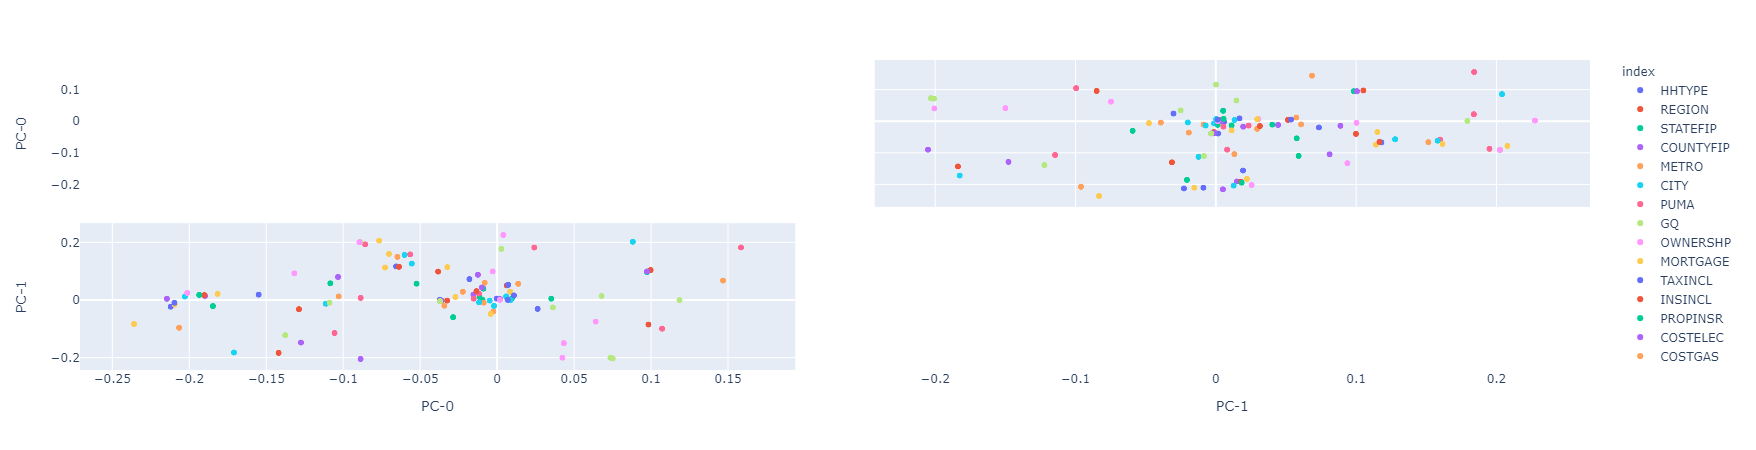

In [75]:
fig = px.scatter_matrix(
    df_pandas,
    dimensions=['PC-0','PC-1'],
    color=df_pandas.index
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [76]:
#save top 5 and bottom 10 loadings so that it gives positive and negative loadings
lb0_pos = df_pandas.sort_values('PC-0', ascending=True).head(8).index.str.cat(sep=' ')
lb0_neg = df_pandas.sort_values('PC-0', ascending=False).head(8).index.str.cat(sep=' ')
lb1_pos = df_pandas.sort_values('PC-1', ascending=True).head(8).index.str.cat(sep=' ')
lb1_neg = df_pandas.sort_values('PC-1', ascending=False).head(8).index.str.cat(sep=' ')

In [77]:
#print results
print('PC0+', lb0_pos)
print('PC0-', lb0_neg)
print('PC1+', lb1_pos)
print('PC1-', lb1_neg)

PC0+ LABFORCE UHRSWORK CLASSWKR HWSEI OCCSCORE LOOKING PWTYPE CARPOOL
PC0- INCTOT MARST HINSCAID HCOVPUB SCHOOL RELATE SCHLTYPE GRADEATT
PC1+ AGE FTOTINC GQ EMPSTAT VETSTAT AVAILBLE HINSCARE GCHOUSE
PC1- MULTGEN FRIDGE BIRTHYR CIDIAL CIOTHSVC CISAT INCTOT NMOTHERS


In [82]:
!jupyter nbconvert ed_squad_final_smn.ipynb --to pdf 

[NbConvertApp] Converting notebook ed_squad_final_smn.ipynb to pdf
/opt/conda/lib/python3.7/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Support files will be in ed_squad_final_smn_files/
[NbConvertApp] Making directory ./ed_squad_final_smn_files
[NbConvertApp] Making directory ./ed_squad_final_smn_files
[NbConvertApp] Making directory ./ed_squad_final_smn_files
[NbConvertApp] Making directory ./ed_squad_final_smn_files
[NbConvertApp] Making directory ./ed_squad_final_smn_files
[NbConvertApp] Making directory ./ed_squad_final_smn_files
[NbConvertApp] Making directory ./ed_squad_final_smn_files
[NbConvertApp] Making directory ./ed_squad_final_smn_files
[NbConvertApp] Making directory ./ed_squad_final_smn_files
[NbConvertApp] Making directory ./ed_squad_final_smn_files
[NbConvertApp] Making directory ./ed_squad_final_smn_files
[NbConvertApp